# Ensemble Slice Sampling

Let's try to implement the Ensemble Slice Sampling algorithm. The algorithm is described in the paper [Ensemble Slice Sampling](https://arxiv.org/abs/2002.06212).

In [1]:
using Distributions, Plots, Random, LinearAlgebra, Turing, StatsPlots

In [2]:
# fun(x, α, β, γ) = @. α * exp(-β * x^2) * cos(γ * x)
rng = MersenneTwister(1234)
fun(x,α,β,γ) = @. α * x^2 + β * x + γ
x = 0.0:0.5:15.0
y = fun(x, 3.0, 0.30, -4)
yerr = (rand(rng,length(x))) .*5
y = randn(rng,length(x)) .* yerr + y;
# plot(x, y, seriestype = :scatter, yerr = yerr, label = "data")
# t = LinRange(0, 5, 1000)
# plot!(t, fun(t, 3.0, 0.30, -4), label = "true function", lw = 4)

31-element Vector{Float64}:
  -1.0537025276521406
  -1.9405165814713492
  -0.8031854289154208
   3.5266013764492596
  10.669519456642929
  19.329770478044804
  23.384965371511058
  32.6581012319408
  43.29759324010011
  57.86766016369845
   ⋮
 358.92863242596474
 394.9082748677422
 433.7138154163123
 468.9129057591675
 506.75441393776117
 548.7608934647141
 588.1680793299371
 629.1265807557348
 670.9041235487568

In [3]:
# using DelimitedFiles
# writedlm("data.txt", [x y yerr])
# data = readdlm("data.txt")

In [10]:
@model function inferenceModel(y)
	α ~ Normal(2, 1)
	β ~ Normal(0, 1)
	γ ~ Normal(-2, 1)

	y ~ MvNormal(fun(x, α, β, γ), 1)
end

n_schools = 8
y = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0] # estimated treatment effects
σ = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]

@model function schools(y, σ)
	μ ~ Normal(0, 5)
	τ ~ truncated(Cauchy(0, 5), lower = 0)
	θ ~ filldist(Normal(μ, τ), n_schools)
	for i in 1:n_schools
		y[i] ~ Normal(θ[i], σ[i])
	end
end

@model function school_reparam(y, σ)
	μ ~ Normal(0, 5)
	τ ~ truncated(Cauchy(0, 5), lower = 0)
	θ ~ filldist(Normal(0, 1), n_schools)
	# y .~ ForEach(μ .+ τ .* θ, σ)
	for i in 1:n_schools
		y[i] ~ Normal(μ + τ * θ[i], σ[i])
	end
end

# logd(X) = (logjoint(inferenceModel(y), (α = X[1], β = X[2], γ = X[3])))
logd(X) = (logjoint(school_reparam(y, σ), (μ = X[1], τ = X[2], θ = X[3:10])))

logd (generic function with 1 method)

In [14]:
typeof(logd)

typeof(logd) (singleton type of function logd, subtype of Function)

In [11]:
using Distributions, Random, LinearAlgebra, StatsBase
using Combinatorics
using ProgressMeter

function tune_lengthscale(t::Int64, μ::Float64, N_e::Int64, N_c::Int64, M_adapt::Int64)
	N_e = max(1, N_e)

	if t <= M_adapt
		return 2μ * N_e / (N_e + N_c)
	else
		return μ
	end
end

function DifferentialMove(μ::Float64, walker_l::AbstractVector{<:Real}, walker_m::AbstractVector{<:Real})
	return μ * (walker_l - walker_m)
end

function sampleMything(rng::Random.AbstractRNG, logdens::Function, walkers::AbstractMatrix{<:Real}, N_iter::Int64, M_adapt::Int64 = 100, max_steps::Int64 = 10^4, μ = 1.0)

	# walkers is of size

	ndim, n_walkers = size(walkers)
	# num of walkers divided by 2
	n_wdiv2 = div(n_walkers, 2)

	logdensities = [logdens(walkers[:, i]) for i in 1:n_walkers]

	# Randomly shuffle the walkers
	walker_indexes = randperm(rng, n_walkers)
	# get the first half of the shuffled walkers
	subset_a = walker_indexes[1:n_wdiv2]
	# get the second half of the shuffled walkers
	subset_b = walker_indexes[n_wdiv2+1:end]
	# get the two subsets
	sets = [[subset_a, subset_b], [subset_b, subset_a]]

	S_save = zeros(ndim, n_walkers, N_iter)

	@showprogress for t in 1:N_iter
		R, L, N_e, N_c = 0, 0, 0, 0

		# loop over the walkers
		for set in sets
			active, inactive = set

			### DifferentialMove ###
			# get all the permutations of the inactive walkers
			permuts = collect(permutations(inactive, 2))
			# get the number of permutations
			pairs = sample(rng, permuts, n_wdiv2, replace = false)
			# iterate over the pairs
			η = hcat([DifferentialMove(μ, walkers[:, p[1]], walkers[:, p[2]]) for p in pairs]...) # (ndim, n_wdiv2)

			# masks the for the left and right stepping
			mask_left = fill(true, n_wdiv2)
			mask_right = fill(true, n_wdiv2)

			# initialise the log densities for the left and right stepping points
			logdensities_left, logdensities_right = Vector{Float64}(undef, n_wdiv2), Vector{Float64}(undef, n_wdiv2)
			position_left, position_right = Matrix{Float64}(undef, ndim, n_wdiv2), Matrix{Float64}(undef, ndim, n_wdiv2)

			# get the move to the new position
			# draw y position 
			δ = rand(rng, Exponential(1), n_wdiv2)
			Y = logdensities[active] - δ

			# interval for the left stepping point
			L = -rand(rng, n_wdiv2)
			# interval for the right stepping point
			R = L .+ 1
			# initialise the counter
			l = 0

			J = floor.(Int, max_steps .* rand(rng, n_wdiv2))
			K = max_steps - 1 .- J

			# stepping out procedure
			while size(mask_left[mask_left], 1) > 0 || size(mask_right[mask_right], 1) > 0

				if size(mask_left[mask_left], 1) > 0
					l += 1
				end
				if size(mask_right[mask_right], 1) > 0
					l += 1
				end
				if l > max_steps
					error("Max steps reached in stepping out")
				end

				for j in (1:n_wdiv2)[mask_left]
					if J[j] < 1
						mask_left[j] = false
					end
				end
				for j in (1:n_wdiv2)[mask_right]
					if K[j] < 1
						mask_right[j] = false
					end
				end
				# println(size(position_left[:, mask_left])," L[mask_left]: ", size(L[mask_left]), " η[:, mask_left]: ", size(η[:, mask_left]), " walkers[:, active]: ", size(walkers[:, active][:, mask_left]))
				position_left[:, mask_left] = L[mask_left]' .* η[:, mask_left] + walkers[:, active][:, mask_left]
				position_right[:, mask_right] = R[mask_right]' .* η[:, mask_right] + walkers[:, active][:, mask_right]

				if size(position_left[:, mask_left], 1) + size(position_right[:, mask_right], 1) < 0
					logdensities_left[mask_left] = []
					logdensities_right[mask_right] = []
					l -= 1
				else
					logdensities_left[mask_left] = [logdens(position_left[:, mask_left][:, i]) for i in 1:size(position_left[:, mask_left], 2)]
					logdensities_right[mask_right] = [logdens(position_right[:, mask_right][:, i]) for i in 1:size(position_right[:, mask_right], 2)]
				end
				for j in (1:n_wdiv2)[mask_left]
					if Y[j] < logdensities_left[j]
						L[j] -= 1
						N_e += 1
						J[j] -= 1
					else
						mask_left[j] = false
					end
				end
				for j in (1:n_wdiv2)[mask_right]
					if Y[j] < logdensities_right[j]
						R[j] += 1
						N_e += 1
						K[j] -= 1
					else
						mask_right[j] = false
					end
				end
			end


			## shrink the interval##
			Widths = Vector{Float64}(undef, n_wdiv2)
			logdensities_shrink = Vector{Float64}(undef, n_wdiv2)
			positions_shrink = Matrix{Float64}(undef, ndim, n_wdiv2)
			mask = fill(true, n_wdiv2)
			l = 0
			while size(mask[mask], 1) > 0

				Widths[mask] = rand(rng, Uniform(), size(mask[mask])) .* (R[mask] - L[mask]) .+ L[mask]

				positions_shrink[:, mask] = Widths[mask]' .* η[:, mask] + walkers[:, active][:, mask]
				logdensities_shrink[mask] = [logdens(positions_shrink[:, mask][:, i]) for i in 1:size(positions_shrink[:, mask], 2)]

				for j in (1:n_wdiv2)[mask]
					if Y[j] < logdensities_shrink[j]
						mask[j] = false
					else
						if Widths[j] < 0.0
							L[j] = Widths[j]
							N_c += 1
						else
							R[j] = Widths[j]
							N_c += 1
						end
					end
				end
				l += 1
				if l > max_steps
					error("Max steps reached in shrink")
				end
			end

			# update the walker
			walkers[:, active] = positions_shrink
			S_save[:, active, t] = positions_shrink
			logdensities[active] = logdensities_shrink
		end
		μ = tune_lengthscale(t, μ, N_e, N_c, M_adapt)

	end
	# chains = Chains(permutedims(S_save, [3, 2, 1]))
	return Chains(permutedims(S_save, [3, 1, 2]))
end

sampleMything (generic function with 4 methods)

In [6]:
rng = MersenneTwister(1234)

# sample_dict = rand(rng,OrderedDict, inferenceModel(y)).vals
sample_dict = rand(rng,OrderedDict, school_reparam(y, σ)).vals
flatten(w) = mapreduce(x -> x, vcat, w)
sample_dict = flatten(sample_dict)

10-element Vector{Float64}:
  4.336736009756228
  5.55763843513345
 -0.4944787535042339
 -0.9029142938652416
  0.8644013132535154
  2.2118774995743475
  0.5328132821695382
 -0.27173539603462066
  0.5023344963886675
 -0.5169836206932686

In [13]:
# f(X) = logjoint(schools(y, σ), (μ=X[1], τ=X[2], θ=X[3:end])) 
n_dims = length(sample_dict)
n_walkers = 50
# S = [flatten(rand(rng,OrderedDict, inferenceModel(y)).vals) for i in 1:n_walkers]
S = [flatten(rand(rng,OrderedDict, school_reparam(y, σ)).vals) for i in 1:n_walkers]
S = hcat(S...)

c = sampleMything(rng,logd,S,20_000)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:07


Chains MCMC chain (20000×10×50 Array{Float64, 3}):

Iterations        = 1:1:20000
Number of chains  = 50
Samples per chain = 20000
parameters        = param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10

Summary Statistics
  parameters      mean        std      mcse     ess_bulk     ess_tail      rha ⋯
      Symbol   Float64    Float64   Float64      Float64      Float64   Float6 ⋯

     param_1    4.1761     3.5274    0.0353   11117.0796    4401.9868    1.058 ⋯
     param_2   31.1695   155.2551    3.4709    7329.1618    2021.2484    1.144 ⋯
     param_3    0.3075     0.9648    0.0053   33232.8550   62574.0134    1.029 ⋯
     param_4    0.0927     0.9120    0.0048   35379.8407   60961.6689    1.069 ⋯
     param_5   -0.0811     0.9431    0.0050   35163.1359   64493.1999    1.068 ⋯
     param_6    0.0472     0.9200    0.0050   34119.4895   60864.3422    1.091 ⋯
     param_7   -0.1478     0.9000    0.0048   35094.1426   56328.9255    1.051 ⋯
     para

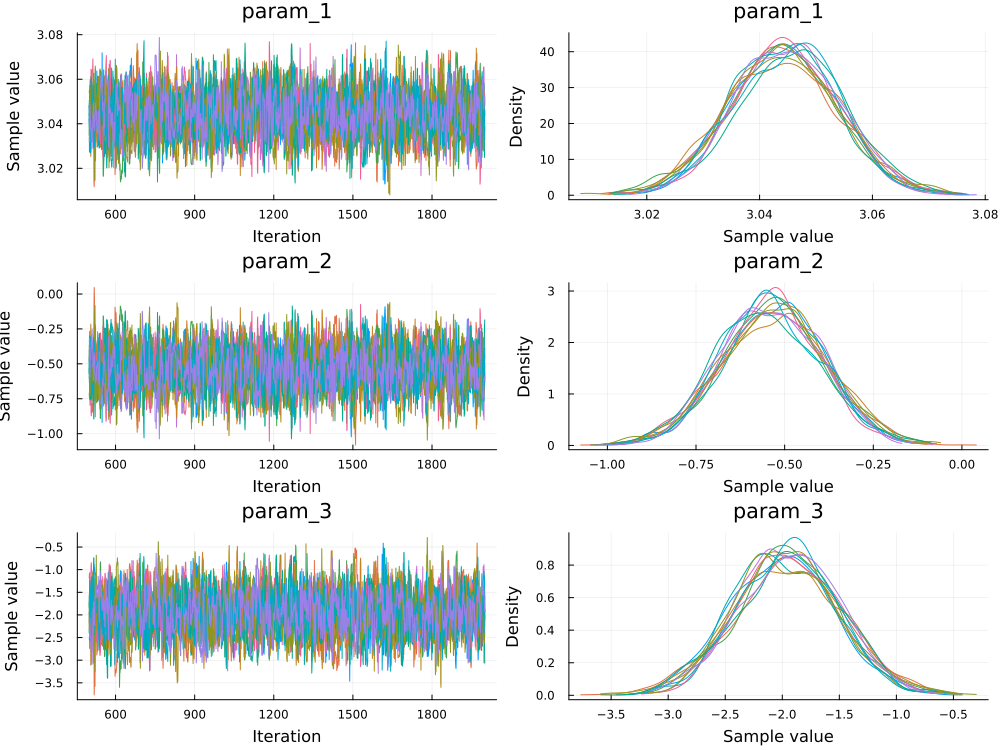

In [10]:
plot(c[500:end,:,:])

In [ ]:
cha

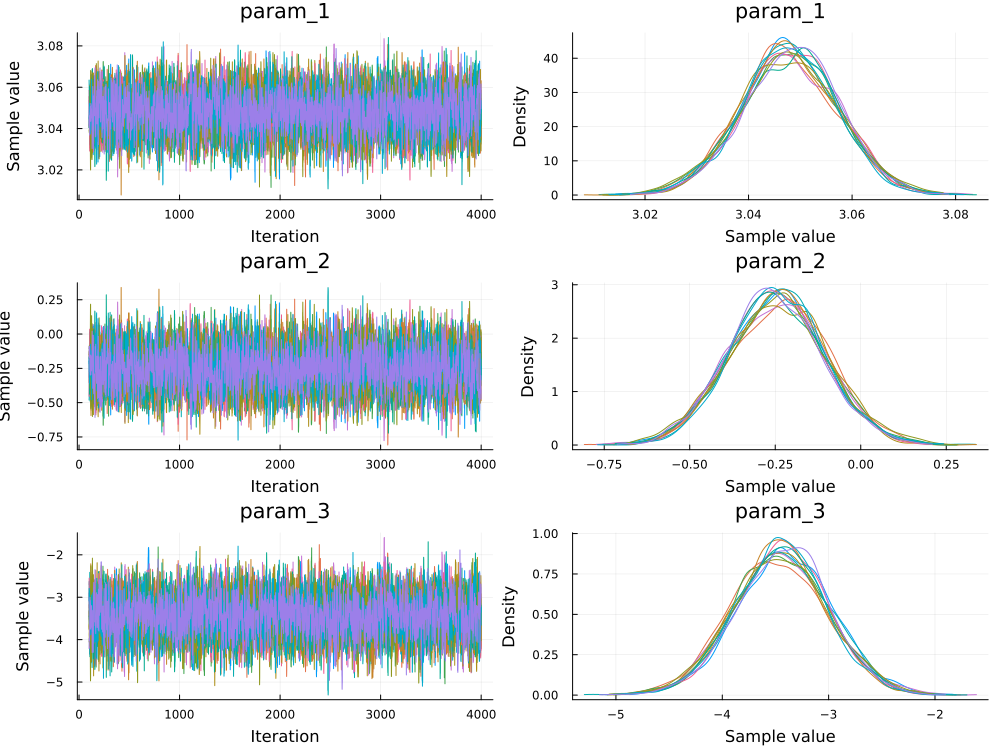

In [51]:
StatsPlots.plot(c[100:end])

In [6]:
function logprior(α, β, γ)
	α_prior = Normal(2, 1)
	β_prior = Normal(0, 1)
	γ_prior = Normal(0, 1)
	return logpdf(α_prior, α) + logpdf(β_prior, β) + logpdf(γ_prior, γ)
end

Σ = diagm(yerr .^ 2)
@model function inferenceModel(y)
	α ~ Normal(2, 1)
	β ~ Normal(0, 1)
	γ ~ Normal(-2, 1)

	y ~ MvNormal(fun(x, α, β, γ), 1)
end


inferenceModel (generic function with 2 methods)

In [7]:
sample_dict = rand(OrderedDict, inferenceModel(y)).vals

3-element Vector{Any}:
  2.240650261436192
  0.9273199649043932
 -1.9256197541029407

In [8]:
logjoint(inferenceModel(y), (α = 3.0, β = 0.30, γ = -4))

-1113.6267350362436

In [6]:
f(X) = (logjoint(inferenceModel(y), (α = X[1], β = X[2], γ = X[3])))

f (generic function with 1 method)

In [7]:
f([0.3,3.0,-4.0])

-164.34014715032566

## Introduction

In [8]:
D = 3 # number of parameters
N = 4*D # number of walkers
N_iter = 10 # number of iterations

10

In [9]:
function tune_lengthscale(t, μ, N_e, N_c, M_adapt)
	if t <= M_adapt
		return 2μ * N_e / (N_e + N_c)
	else
		return μ
	end
end


tune_lengthscale (generic function with 1 method)

Initialise the Walkers

In [10]:
rng = MersenneTwister(1234)
S = [ rand(rng,OrderedDict,inferenceModel(y)).vals for i in 1:N ]

function get_complementary(i, N)
    indices = collect(1:N)
    deleteat!(indices, i)
    return indices
end

get_complementary (generic function with 1 method)

In [40]:
function get_direction_vector(S, l, m, μ)
	return μ * (S[l] - S[m])
end

function DifferentialMove(rng,k, μ, S)
	# work on walker k
	indices = get_complementary(k, N)
	# draw two random indices from the complementary set, without replacement
	l, m = sample(rng,indices, 2, replace = false)
	return get_direction_vector(S, l, m, μ)
end

DifferentialMove (generic function with 2 methods)

### small test

In [43]:
rng = MersenneTwister(42)
# sample_dict = rand(OrderedDict, inferenceModel(y)).vals
N2 = convert(Int, N / 2)
S = [rand(rng, OrderedDict, inferenceModel(y)).vals for i in 1:N]

R, L, N_e, N_c = 0, 0, 0, 0
X′ = 0
μ = 1.0

k = 1
Xₖ = S[k] # get the current position of walker k
ηₖ = DifferentialMove(rng,k, μ, S) # get the differential move
# Y  = rand(rng) * f(Xₖ)
Y = f(Xₖ) - rand(rng,Exponential())

L = -rand(rng)
R = L + 1

while Y < f(L .* ηₖ + Xₖ) 
    L = L - 1
    N_e = N_e + 1
end
while Y < f(R .* ηₖ + Xₖ)
    R = R + 1
    N_e = N_e + 1
end
println(L," ", R)
println(N_e, " ", N_c)

l = 0
max_steps = 1000
while true && l < max_steps
	l += 1
	X′ = rand(rng,Uniform(L, R))
	Y′ = f(X′ .* ηₖ + Xₖ)
	if Y < Y′
		break
	end
	if X′ < 0
		L = X′
		N_c = N_c + 1
	else
		R = X′
		N_c = N_c + 1
	end
end
@assert l < max_steps


-0.615499883091533 57060.38450011691
57060 0


### big loop

In [44]:
rng = MersenneTwister(142)
# sample_dict = rand(OrderedDict, inferenceModel(y)).vals
N2 = convert(Int, N / 2)
S = [rand(rng, OrderedDict, inferenceModel(y)).vals for i in 1:N]


N_iter = 20
S_save = zeros(N, D, N_iter);
μ_values = zeros(N_iter)
R_values = zeros(N_iter)
L_values = zeros(N_iter)
N_e_values = zeros(N_iter)
N_c_values = zeros(N_iter)
bad = []
μ = 1.0
M_adapt = 10
max_steps = 1000
for t in 1:N_iter
	println("Iteration: ", t)
	R, L, N_e, N_c = 0, 0, 0, 0
	X′ = 0

	# loop over the walkers
	for k in 1:N
		# println("Walker: ", k)

		Xₖ = S[k] # get the current position of walker k
		ηₖ = DifferentialMove(rng,k, μ, S) # get the differential move
		# Y  = rand(rng) * f(Xₖ)
		Y = f(Xₖ) - rand(rng,Exponential(1))

		L = -rand(rng)
		R = L + 1

		while Y < f(L .* ηₖ + Xₖ) 
			L = L - 1
			N_e = N_e + 1
		end
		while Y < f(R .* ηₖ + Xₖ)
			R = R + 1
			N_e = N_e + 1
		end

		l = 0
		while true && l < max_steps
			l += 1
			X′ = rand(rng,Uniform(L, R))
			Y′ = f(X′ .* ηₖ + Xₖ)
			if Y < Y′
				break
			end
			if X′ < 0
				L = X′
				N_c = N_c + 1
			else
				R = X′
				N_c = N_c + 1
			end
		end
		# println("Steps: ", l)
		if l == max_steps
			println("Max steps reached")
			push!(bad, [t,k])
		end
		Xₖ = X′ .* ηₖ + Xₖ
		S_save[k, :, t] = Xₖ
		S[k] = Xₖ
	end
	μ_values[t] = μ
	R_values[t] = R
	L_values[t] = L
	N_e_values[t] = N_e
	N_c_values[t] = N_c
	μ = tune_lengthscale(t, R - L, N_e, N_c, M_adapt)
end

Iteration: 1


InterruptException: InterruptException:

In [ ]:
using MCMCChains

In [ ]:
chains = Chains(permutedims(S_save, [3, 2, 1]))

In [ ]:
chains[500:end,:,:]

In [ ]:
plot(chains[500:end,:,:])

In [ ]:
# w = 0
# while true
#     w +=1
#     if w > 100
#         break
#     end
# end
# print